## import des librairies & chargement des dataset

In [15]:
import os.path

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate, cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [16]:
FD_wIP = "./Fraud_Data_wIP.csv"


if os.path.isfile(FD_wIP):
    fd = pd.read_csv(FD_wIP)
    build_it = 0

else:
    fd = pd.read_csv("Fraud_Data.csv")
    geoip = pd.read_csv("IpAddress_to_Country.csv")
    geoip = geoip.reset_index().rename({'index':'bloc'}, axis=1)
    build_it = 1


In [17]:
if not build_it :
    print("dataset with countries found and loaded from file.")
else:
    print("dataset with countries not found, need to build it...")

dataset with countries found and loaded from file.


## Ajout des pays, via les addresses IP du dataset geoip.

In [18]:
if build_it :

        fd.ip_address = fd.ip_address.astype(float)

        # 
        # on va construire une liste de paires (index, pays)
        # puis joindre avec le dataset d'origine
        # 

        row_list = []

        # un itérateur pour chaque table
        geoip_gen = geoip.iterrows()
        fds_gen = fd.sort_values(by='ip_address').iterrows()

        # une fonction pour itérer sur la table fraud 
        def next_ip(g):
                i_fds, row_fds = next(g)
                ip = row_fds['ip_address']
                return i_fds, ip

        # initialisation
        #l, u, c = tuple(next(geoip_gen)[1])
        # ou , si bloc
        b, l, u, c = tuple(next(geoip_gen)[1])
        i_fds, ip = next_ip(fds_gen)

        # parcours et identification du pays
        while(True):
                try:
                        if ip < l:                
                                i_fds, ip = next_ip(fds_gen)
                        
                        elif l <= ip <= u:
                                #row_list.append((i_fds, c))
                                # ou si bloc
                                row_list.append((i_fds, c, b))
                                i_fds, ip = next_ip(fds_gen)
                        
                        elif ip > u:
                                #l, u, c = tuple(next(geoip_gen)[1])
                                # ou , si bloc
                                b, l, u, c = tuple(next(geoip_gen)[1])
                except Exception as e :
                        break        


        pivot = pd.DataFrame(row_list, columns=['index', 'country', 'bloc'])
        pivot.set_index('index', inplace=True)

        # le resultat = notre dataset avec une colonne country en plus
        fd = fd.join(pivot)
        fd.to_csv("Fraud_Data_wIP.csv")

        # free memory
        del(geoip)
        del(row_list)

In [19]:
fd.head()

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,bloc
0,0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4554.0
1,1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1017.0
2,2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,43965.0
3,3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,NaN
4,4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1604.0


## cleaning, fillna, cast dates  

In [20]:
# un nouvel user_id à chaque observation, cette variable n'apporte pas d'information 

fd.user_id.value_counts().max()

1

In [21]:
# remove columns with no useful information

todrop = ['user_id', 'Unnamed: 0', 'ip_address']
fd.drop(todrop, axis=1, inplace=True)

In [22]:
# cast the columns with dates to datetime

fd.signup_time = pd.to_datetime(fd.signup_time)
fd.purchase_time = pd.to_datetime(fd.purchase_time)

In [23]:
# replace NaN in country and bloc
fd.country.fillna(value='n.a.', inplace=True)
fd.bloc.fillna(value='n.a', inplace=True)


In [24]:
fd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   signup_time     151112 non-null  datetime64[ns]
 1   purchase_time   151112 non-null  datetime64[ns]
 2   purchase_value  151112 non-null  int64         
 3   device_id       151112 non-null  object        
 4   source          151112 non-null  object        
 5   browser         151112 non-null  object        
 6   sex             151112 non-null  object        
 7   age             151112 non-null  int64         
 8   class           151112 non-null  int64         
 9   country         151112 non-null  object        
 10  bloc            151112 non-null  object        
dtypes: datetime64[ns](2), int64(3), object(6)
memory usage: 12.7+ MB


## exploration, feature eng. 

### Feature : device_id

certain device_id sont réutilisé plusieurs fois ?



In [25]:
# feature engineering => add a column (device_id_new) with 'Y'/'N' if the device_id is a new one (never seen before)

# device id usage
did = fd.device_id.value_counts()

did[did >  1] = 0
did[did == 1] = 1


fd = fd.join(did, on='device_id', rsuffix="_did")
fd.rename(columns={'device_id_did': 'device_id_new'}, inplace=True)

# trash 
del(did)

In [26]:
# il y a une corrélation interessante entre device_id_new et la classe 
fd.corr()

,purchase_value,age,class,device_id_new
purchase_value,1.000000,0.002370,0.001011,-0.000927
age,0.002370,1.000000,0.006624,-0.007796
class,0.001011,0.006624,1.000000,-0.566548
device_id_new,-0.000927,-0.007796,-0.566548,1.000000


### Feature : age

- faire des classes d'age
- voir les caractéristiques (moyennes ?) par classe d'age (purchase value et autres)


In [27]:

def age_classe(a, r=5, maxi=55, mini=20):
    if int(a) > maxi :
        return str(maxi+1) + '+'
    elif int(a) < mini :
        return '-' + str(mini)
    else:
        return str(r * (a//r)) + '-' + str(min(r * (a//r) + r - 1, maxi))

fd['age_group'] = fd.age.apply(lambda x : age_classe(x, maxi=54))

In [28]:
fd.groupby(['age_group'])['purchase_value', 'class'].mean()

,purchase_value,class
age_group,,
-20,36.464361,0.090332
20-24,37.291862,0.093589
25-29,36.681963,0.086230
30-34,36.917630,0.095714
35-39,36.826871,0.098477
40-44,37.287728,0.096631
45-49,36.868234,0.085979
50-54,36.758604,0.103250
55+,37.537450,0.100057


### frequence des achats ... ou delta avec le dernier achat ... ou pas...

In [29]:
## add day name
#fd['purchase_day'] = fd.purchase_time.apply(lambda x: x.day_name())

## add delta in sec. with signup time
fd['delta_sec'] = (fd.purchase_time - fd.signup_time).apply(lambda x : np.log10((x.days * 86400) + x.seconds))

In [31]:
fd.groupby(['delta_sec']).count()


,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,class,country,bloc,device_id_new,age_group
delta_sec,,,,,,,,,,,,,
0.000000,7600,7600,7600,7600,7600,7600,7600,7600,7600,7600,7600,7600,7600
2.136721,1,1,1,1,1,1,1,1,1,1,1,1,1
2.394452,1,1,1,1,1,1,1,1,1,1,1,1,1
2.494155,1,1,1,1,1,1,1,1,1,1,1,1,1
2.641474,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7.015682,1,1,1,1,1,1,1,1,1,1,1,1,1
7.015685,1,1,1,1,1,1,1,1,1,1,1,1,1
7.015687,1,1,1,1,1,1,1,1,1,1,1,1,1


In [32]:
fd[(fd['class']==1) & (fd['purchase_time'] < '13-01-2015')].set_index('purchase_time').sort_index()
# etrange ... probablement des tests. a virer pour ne pas polluer le modèle ?

## drop all samples before 14.01.2015, as they seem to be mostly tests with class=1
#fd.drop(fd[fd['purchase_time'] < '14-01-2015'].index, inplace=True)


,signup_time,purchase_value,device_id,source,browser,sex,age,class,country,bloc,device_id_new,age_group,delta_sec
purchase_time,,,,,,,,,,,,,
2015-01-01 00:00:44,2015-01-01 00:00:43,14,BBPACGBUVJUXF,Ads,Chrome,F,38,1,Korea Republic of,35743,0,35-39,0.0
2015-01-01 00:00:45,2015-01-01 00:00:44,14,BBPACGBUVJUXF,Ads,Chrome,F,38,1,Korea Republic of,35743,0,35-39,0.0
2015-01-01 00:00:46,2015-01-01 00:00:45,14,BBPACGBUVJUXF,Ads,Chrome,F,38,1,Korea Republic of,35743,0,35-39,0.0
2015-01-01 00:00:47,2015-01-01 00:00:46,14,BBPACGBUVJUXF,Ads,Chrome,F,38,1,Korea Republic of,35743,0,35-39,0.0
2015-01-01 00:00:48,2015-01-01 00:00:47,14,BBPACGBUVJUXF,Ads,Chrome,F,38,1,Korea Republic of,35743,0,35-39,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-12 23:56:08,2015-01-12 23:56:07,36,FKJIKBFSELVXT,SEO,Chrome,F,29,1,United Kingdom,89839,0,25-29,0.0
2015-01-12 23:56:09,2015-01-12 23:56:08,36,FKJIKBFSELVXT,SEO,Chrome,F,29,1,United Kingdom,89839,0,25-29,0.0
2015-01-12 23:56:10,2015-01-12 23:56:09,36,FKJIKBFSELVXT,SEO,Chrome,F,29,1,United Kingdom,89839,0,25-29,0.0


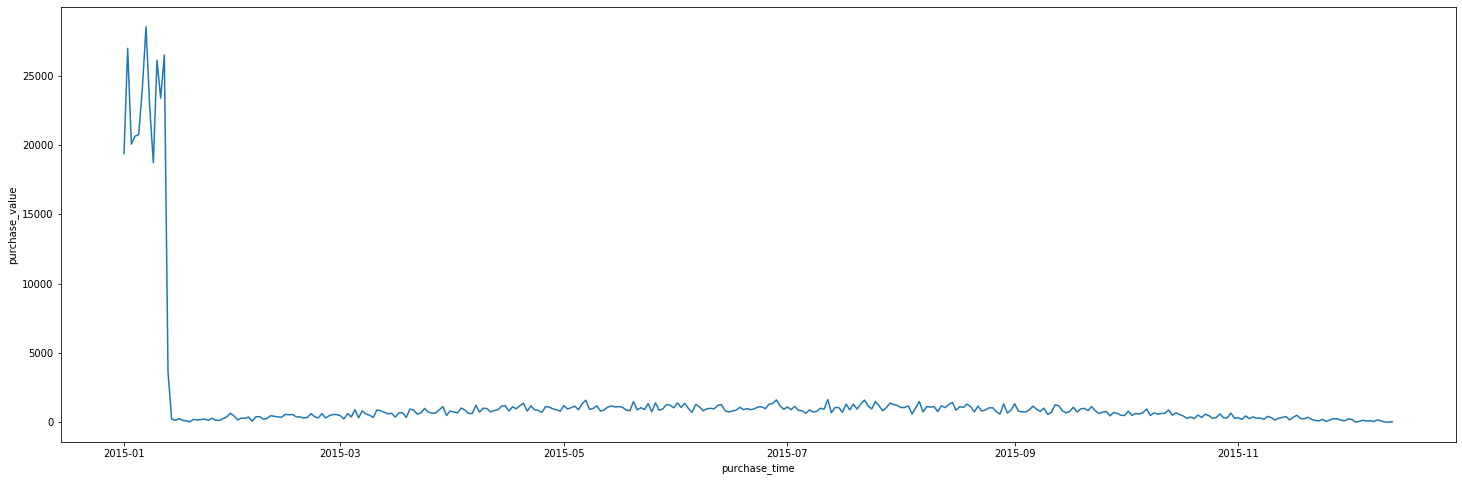

In [33]:
from matplotlib import pyplot
fig, ax = pyplot.subplots(figsize=(25,8))

tmp = fd[(fd['class']==1)].set_index('purchase_time').resample('1d').sum()
_ = sns.lineplot(x=tmp.index, y='purchase_value', data=tmp)

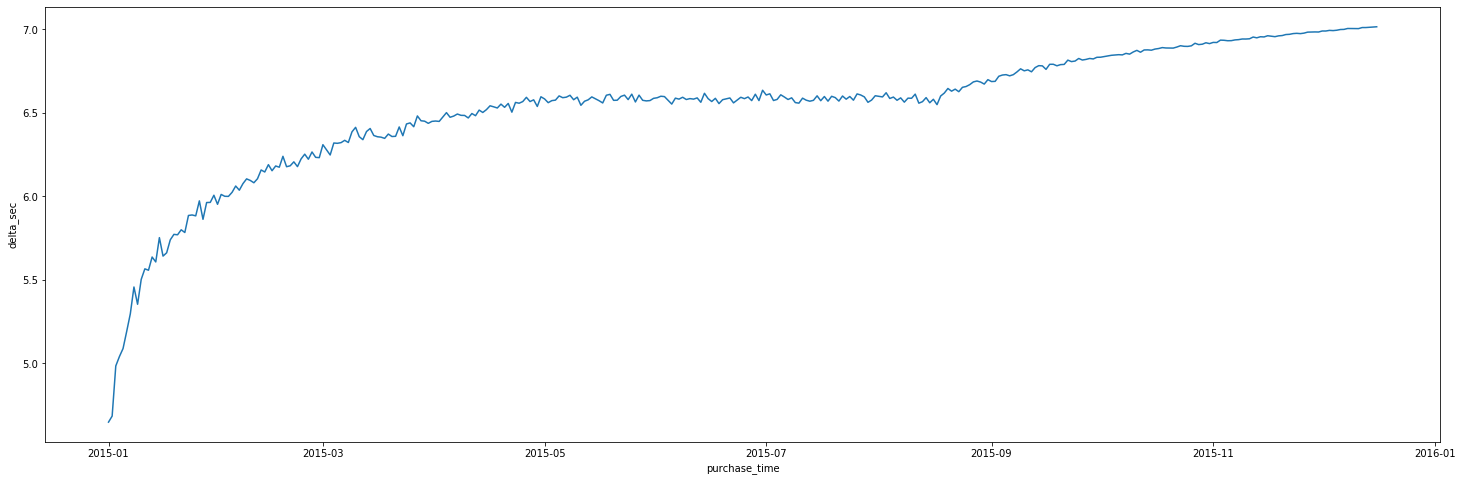

In [34]:
from matplotlib import pyplot
fig, ax = pyplot.subplots(figsize=(25,8))

tmp = fd[fd['class']==0].set_index('purchase_time').resample('1d').mean()
_ = sns.lineplot(x=tmp.index, y='delta_sec', data=tmp)

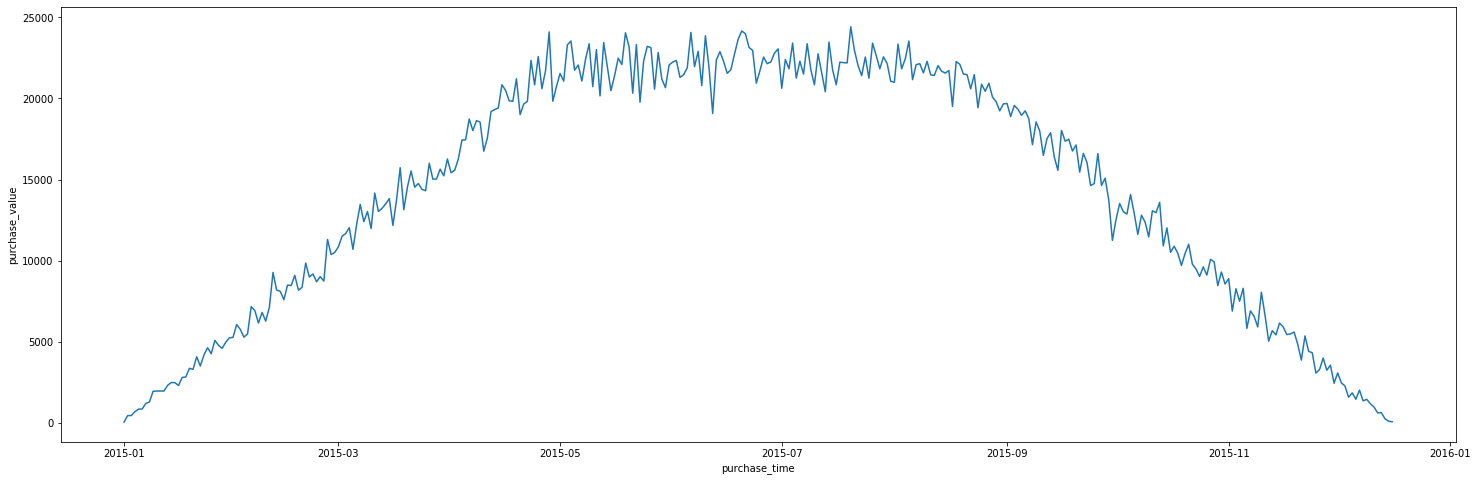

In [40]:
from matplotlib import pyplot
fig, ax = pyplot.subplots(figsize=(25,8))

tmp = fd[fd['class']==0].set_index('purchase_time').resample('1d').sum().reset_index()

_ = sns.lineplot(x='purchase_time', y='purchase_value', data=tmp)


### source, browser, sex

voir si ces features ont un interet pour notre prédiction de classe


In [33]:
fd.groupby('sex').mean()

,purchase_value,age,class,device_id_new,delta_sec
sex,,,,,
F,36.914758,33.092321,0.045162,0.918500,6.588356
M,36.956244,33.139214,0.046009,0.918636,6.586586


In [34]:
fd.groupby('source').mean()

# ==> source Direct a quelques fraudeur de plus...

,purchase_value,age,class,device_id_new,delta_sec
source,,,,,
Ads,36.953579,33.130304,0.044040,0.917740,6.586417
Direct,36.915812,33.157051,0.054267,0.919587,6.589695
SEO,36.936161,33.090408,0.042925,0.918901,6.587027


In [35]:
fd.groupby('browser').mean()
# non 

,purchase_value,age,class,device_id_new,delta_sec
browser,,,,,
Chrome,37.008891,33.099083,0.045494,0.918941,6.585007
FireFox,36.931878,33.104440,0.045558,0.918554,6.588331
IE,36.782119,33.144359,0.045358,0.919509,6.586282
Opera,36.621074,32.837521,0.045688,0.911765,6.583685
Safari,37.055162,33.190809,0.046594,0.917342,6.594133


### country

- pays important vs non-importants 

- tendances / spécifiques par pays ?

- frequence d'achat et purchase_value moyenne par pays ?


In [109]:
#ctry_cnt = fd.country.value_counts()

In [110]:
def country_classifier(c):
    
    if c == 'n.a.':
            return 'n.a.'
     
    if ctry_cnt[c] < 200: 
        return 'less-200'
    else:
        return c



In [111]:
#fd['country_group'] = fd.country.apply(lambda x : country_classifier(x))

In [41]:
fd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   signup_time     151112 non-null  datetime64[ns]
 1   purchase_time   151112 non-null  datetime64[ns]
 2   purchase_value  151112 non-null  int64         
 3   device_id       151112 non-null  object        
 4   source          151112 non-null  object        
 5   browser         151112 non-null  object        
 6   sex             151112 non-null  object        
 7   age             151112 non-null  int64         
 8   class           151112 non-null  int64         
 9   country         151112 non-null  object        
 10  bloc            151112 non-null  object        
 11  device_id_new   151112 non-null  int64         
 12  age_group       151112 non-null  object        
 13  delta_sec       151112 non-null  float64       
dtypes: datetime64[ns](2), float64(1), in

## creation de modele ML

### préparation  : 

- dummification
- train/test split


In [42]:
# remove columns with no useful information

todrop = ['signup_time', 'device_id', 'age', 'browser', 'sex'] #'country'
fd.drop(todrop, axis=1, inplace=True)

fd.set_index('purchase_time', inplace=True)


In [43]:
fd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 151112 entries, 2015-04-18 02:47:11 to 2015-07-21 02:03:53
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   purchase_value  151112 non-null  int64  
 1   source          151112 non-null  object 
 2   class           151112 non-null  int64  
 3   country         151112 non-null  object 
 4   bloc            151112 non-null  object 
 5   device_id_new   151112 non-null  int64  
 6   age_group       151112 non-null  object 
 7   delta_sec       151112 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 10.4+ MB


In [44]:

def dummifie(l):
    tmp = pd.get_dummies(fd[l], drop_first=True)
    fd[tmp.columns] = tmp
    fd.drop(l, axis=1, inplace=True)
    del(tmp)

dummifie(['source'])

dummifie(['country'])

dummifie(['age_group']) 



In [45]:
fd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 151112 entries, 2015-04-18 02:47:11 to 2015-07-21 02:03:53
Columns: 196 entries, purchase_value to age_group_55+
dtypes: float64(1), int64(3), object(1), uint8(191)
memory usage: 34.4+ MB


In [46]:
from sklearn.model_selection import train_test_split

X = fd.drop(['class'], axis=1)
y = fd['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)


In [48]:
#
# flag des pays et bloc qui ont un taux de Fraud supérieur aux autres
#
# sur X_train uniquement

X_train_tmp = pd.concat([X_train, y_train], axis = 1)

blocs = pd.concat([X_train_tmp.groupby(['bloc'])['class'].count(), X_train_tmp.groupby(['bloc'])['class'].mean()], axis=1)

blocs.columns = ['count','mean']
blocs.loc[(blocs['mean'] == 0) ,'bloc_group'] = 'clean'
blocs.loc[(blocs['mean'] > 0) ,'bloc_group'] = 'spot'
blocs.drop(['count','mean'], axis=1, inplace=True)

# rajout d'une colonne bloc_group (valeur = 'clean' ou 'spot')
#
X_train = X_train.join(blocs, on='bloc')
X_test = X_test.join(blocs, on='bloc')

X_train.drop(['bloc'], axis=1, inplace=True)
X_test.drop(['bloc'], axis=1, inplace=True)

# dummification
# 
X_train['spot'] = pd.get_dummies(X_train['bloc_group'], drop_first=True)
X_train.drop(['bloc_group'], axis=1, inplace=True)

X_test['spot'] = pd.get_dummies(X_test['bloc_group'], drop_first=True)
X_test.drop(['bloc_group'], axis=1, inplace=True)


del(blocs)
X_train.head()


,purchase_value,device_id_new,delta_sec,source_Direct,source_SEO,country_Albania,country_Algeria,country_Angola,country_Antigua and Barbuda,country_Argentina,...,country_n.a.,age_group_20-24,age_group_25-29,age_group_30-34,age_group_35-39,age_group_40-44,age_group_45-49,age_group_50-54,age_group_55+,spot
purchase_time,,,,,,,,,,,,,,,,,,,,,
2015-03-10 22:50:06,83,1,6.637912,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2015-07-11 21:45:27,59,0,6.748331,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2015-07-23 04:07:15,20,1,6.550902,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2015-10-18 20:53:44,55,1,6.977437,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2015-04-10 10:56:17,13,1,6.925979,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
## meme idée sur country, mais inutile si on garde les country. (aurait été utile si on garde que des classes de pays)

#ctry_mean = fd.groupby('country').mean().sort_values(by='class', ascending=False)['class']
#ctry_mean[:20]

def pays_fraudeur(c):
    if ctry_mean[c] > 0.10 :
        return 'Oui'
    else:
        return 'Non'

#fd['pays_fraudeur'] = fd.country.apply(lambda x : pays_fraudeur(x))


### modele baseline : score ?

In [53]:
y_pred = y_test.copy()
y_pred[:] = 0

print(classification_report(y_test, y_pred))


precision    recall  f1-score   support

           0       0.91      1.00      0.95     45197
           1       0.00      0.00      0.00      4670

    accuracy                           0.91     49867
   macro avg       0.45      0.50      0.48     49867
weighted avg       0.82      0.91      0.86     49867



### modèle reg logistique

- normalisation
- parametres standards, score, coefs, matrice de confusion
- amélioration avec gridsearch



In [54]:
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(class_weight='balanced'))
])

#pipe_lr.fit(X_train, y_train)


params = {'logreg__penalty': ['l2'], 
            'logreg__C': [0.00005],
            'logreg__solver' : ['lbfgs']
}

grid_search = GridSearchCV(pipe_lr, params, cv=3, n_jobs=1) 

grid_search.fit(X_train, y_train)



GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logreg',
                                        LogisticRegression(C=1.0,
                                                           class_weight='balanced',
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='auto',
    

In [55]:
print(grid_search.best_params_)
print(grid_search.best_score_)


{'logreg__C': 5e-05, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}
0.93311277224498


In [48]:
kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=kfold)
print(results.mean())
print()
print(results)


0.8284347075154818

[0.81763172 0.83044658 0.82481219 0.83065526 0.83034224 0.83681135
 0.83013356 0.83295075 0.81844741 0.83211603]


In [56]:
y_pred = grid_search.best_estimator_.predict(X_test)
acc_score = accuracy_score(y_pred, y_test)
print("score : {}".format(acc_score))

score : 0.9257625283253454


In [57]:
#matrice de confusion
conf_mat = pd.DataFrame({'target':y_test , 'prediction': y_pred}).reset_index()
conf_mat.groupby(['target', 'prediction']).count()

purchase_time
target prediction               
0      0                   43144
       1                    2053
1      0                    1649
       1                    3021

In [58]:
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))


precision    recall  f1-score   support

           0       0.96      0.95      0.96     45197
           1       0.60      0.65      0.62      4670

    accuracy                           0.93     49867
   macro avg       0.78      0.80      0.79     49867
weighted avg       0.93      0.93      0.93     49867



In [71]:
for k,v in pd.DataFrame(abs(grid_search.best_estimator_.named_steps['logreg'].coef_), columns=X_train.columns).T.sort_values(by=0, ascending=False).iterrows():
    print("{:<30} {:<30}".format(k,v.values[0]))

device_id_new                  0.455190077452008             
spot                           0.43761516412532064           
delta_sec                      0.4159329915157072            
country_n.a.                   0.03855535642162025           
source_Direct                  0.023184818815791892          
country_Hong Kong              0.019450418579613372          
country_Belgium                0.017683413914597552          
country_Latvia                 0.01603724727723777           
country_New Zealand            0.015482402293761193          
country_Morocco                0.014681706558639979          
country_Chile                  0.01454551553727247           
source_SEO                     0.014232762706301107          
country_Russian Federation     0.013901974958306293          
country_Malta                  0.013870233863083644          
country_Canada                 0.013406518299562836          
country_Saudi Arabia           0.01240182249095188           
country_

## creation d'un modèle  DecisionTree

In [72]:
from sklearn.tree import DecisionTreeClassifier

In [75]:

#params = {
#            'criterion': ["gini", "entropy"], 
#            'max_depth' : [5,7,12],
#            'min_samples_split' : [3, 7, 11, 21],
#          'class_weight' : ['balanced'],
#            'max_features' : [2,3, 5, 7]
#         }

params = {'criterion': ['gini'], 
        #'max_depth': [22], 
        'max_features': [3], 
        'min_samples_split': [18], 
            'class_weight' : [{0:0.05, 1:0.95}] #['balanced']
            }

grid_search = GridSearchCV(DecisionTreeClassifier(), params, cv=3, n_jobs=1)

grid_search.fit(X_train, y_train)


print(grid_search.best_params_)
print(grid_search.best_score_)
print("-"*60)

#predicion
y_pred = grid_search.best_estimator_.predict(X_test)

#matrice de confusion
conf_mat = pd.DataFrame({'target':y_test , 'prediction': y_pred}).reset_index()
print(conf_mat.groupby(['target', 'prediction']).count())



{'class_weight': {0: 0.05, 1: 0.95}, 'criterion': 'gini', 'max_features': 3, 'min_samples_split': 18}
0.8166033272570014
------------------------------------------------------------
                   purchase_time
target prediction               
0      0                   37476
       1                    7721
1      0                    1609
       1                    3061


In [76]:
coefs = pd.DataFrame(grid_search.best_estimator_.feature_importances_, index=X_train.columns).sort_values(by=0, ascending=False)
coefs

,0
delta_sec,0.326809
device_id_new,0.256154
spot,0.189043
purchase_value,0.145923
source_Direct,0.005454
...,...
country_Lesotho,0.000000
country_Tajikistan,0.000000
country_Burundi,0.000000
country_Burkina Faso,0.000000


### Random Forest

In [77]:

params = {'criterion': ['gini'], 
       # 'max_depth': [22], 
        'max_features': [3], 
        'min_samples_split': [18], 
            'class_weight' : [{0: 0.05, 1: 0.95}]
            }


grid_search = GridSearchCV(RandomForestClassifier(n_estimators=100), params, cv=3, n_jobs=1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
print("-"*60)

#predicion
y_pred = grid_search.best_estimator_.predict(X_test)

#matrice de confusion
conf_mat = pd.DataFrame({'target':y_test , 'prediction': y_pred}).reset_index()
print(conf_mat.groupby(['target', 'prediction']).count())


{'class_weight': {0: 0.05, 1: 0.95}, 'criterion': 'gini', 'max_features': 3, 'min_samples_split': 18}
0.926574173160136
------------------------------------------------------------
                   purchase_time
target prediction               
0      0                   42781
       1                    2416
1      0                    1762
       1                    2908


In [78]:
confusion_matrix(y_test, y_pred)

array([[42781,  2416],
       [ 1762,  2908]], dtype=int64)

## utilisation de PCA et LDA 

In [108]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)

X_lda = lda.fit_transform(X_train,y_train)



In [109]:
print(lda.coef_)
print()
print(lda.explained_variance_ratio_)

[[ 1.16465518e-04 -4.57252930e+00  3.92011481e-02  2.53680483e-01
  -4.39330748e-02 -3.73568277e+00 -3.06390648e+00 -3.21709569e+00
  -2.65086052e+00 -2.31596431e+00  1.44381542e+00 -2.51684180e+00
  -2.43186131e+00 -1.49262490e+00 -2.83874724e+00 -3.09505438e+00
  -5.41823728e-01 -3.39238271e+00 -2.23980339e+00 -1.99800235e+00
  -2.70766523e+00 -2.62168581e+00 -2.67730096e+00 -2.66805737e+00
  -1.69887664e-01 -7.16761951e+00 -2.16900663e+00 -7.24805347e+00
  -2.52332087e+00 -2.42044196e+00 -2.72448761e+00 -2.79608776e+00
  -2.63805207e+00  4.78032778e-17 -3.18646305e+00 -2.75047314e+00
  -2.56739329e+00  1.22361729e-17 -2.69104590e+00 -2.15789679e+00
  -3.10957324e+00 -2.75363165e+00 -2.68297145e+00 -2.64993444e+00
  -2.91446381e+00  2.01524401e+00 -2.36075879e+00 -2.65810679e+00
  -2.70936378e+00 -2.45237480e+00 -2.48125701e+00 -2.19048968e+00
  -1.32459543e-17  4.10165322e-18 -1.93220194e+00 -2.55117904e+00
  -2.79006617e+00 -1.71313533e+00 -2.86674015e+00 -2.71013309e+00
  -2.79162

### PCA ...

In [79]:
normalizer = StandardScaler().fit(X_train)

X_train_norm = pd.DataFrame(normalizer.transform(X_train), columns=X_train.columns)
X_test_norm = pd.DataFrame(normalizer.transform(X_test), columns=X_test.columns)

from sklearn.decomposition import PCA
pca = PCA(n_components=9)

X_train_pca = pd.DataFrame(pca.fit_transform(X_train_norm)  ) #, columns=['principal component ' + str(i) for i in range(1,4)])
X_test_pca  = pd.DataFrame(pca.transform(X_test_norm)  ) #, columns=['principal component ' + str(i) for i in range(1,4)])

pd.DataFrame(pca.components_, columns=X_train.columns).T.sort_values(by=1)

# voir les modèles précédents sur X_train_pca..

,0,1,2,3,4,5,6,7,8
source_Direct,0.028012,-0.624222,0.172579,-0.222209,0.019050,0.004794,0.015407,0.021931,-0.006756
country_United States,0.083433,-0.236686,0.159644,0.753356,0.041981,0.010235,-0.018256,0.007141,0.007568
country_Norway,-0.009336,-0.053794,-0.084884,-0.016784,-0.012194,0.001774,0.098700,-0.138237,0.023072
country_Ecuador,0.027714,-0.045200,-0.046330,-0.032149,0.085465,-0.012757,0.011884,0.044837,0.012724
country_Nigeria,-0.028597,-0.040328,-0.018514,-0.004121,-0.037986,0.022803,0.014080,0.013283,-0.011311
...,...,...,...,...,...,...,...,...,...
device_id_new,-0.564337,0.074103,0.357288,0.009908,0.039576,0.026355,0.021046,-0.004578,0.005980
delta_sec,-0.573739,0.075929,0.354056,0.013400,0.035000,0.018971,0.017498,0.005067,0.003521
spot,0.463143,0.147042,0.426737,-0.023853,-0.020252,0.029741,0.009150,0.007155,-0.011832
country_n.a.,0.225309,0.287210,0.465588,-0.308240,-0.005446,0.012155,-0.010191,-0.024476,0.072897


In [83]:
params = {'criterion': ['gini'], 
      #  'max_depth': [10], 
        'max_features': [3], 
        'min_samples_split': [18], 
            'class_weight' : [{0: 0.05, 1: 0.95}]
            }


grid_search = GridSearchCV(RandomForestClassifier(n_estimators=50), params, cv=3, n_jobs=1)

grid_search.fit(X_train_pca, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
print("-"*60)

#predicion
y_pred = grid_search.best_estimator_.predict(X_test_pca)

#matrice de confusion
conf_mat = pd.DataFrame({'target':y_test , 'prediction': y_pred}).reset_index()
print(conf_mat.groupby(['target', 'prediction']).count())

{'class_weight': {0: 0.05, 1: 0.95}, 'criterion': 'gini', 'max_features': 3, 'min_samples_split': 18}
0.9360462390280976
------------------------------------------------------------
                   purchase_time
target prediction               
0      0                   44605
       1                     592
1      0                    2038
       1                    2632


## Naive bayes

In [82]:
## ada / xg boost

In [84]:
from xgboost import XGBRegressor
import xgboost

In [123]:
xgb = XGBRegressor(n_estimators=100, random_state=0, booster='gbtree', objective='binary:logistic')

params = {
    'learning_rate' : [0.2, 0.4, 0.6, 0.8, 1., 1.2]
    }

grid_search = GridSearchCV(xgb, params, cv=3, n_jobs=1)

grid_search.fit(X_train_pca, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
print("-"*60)


{'learning_rate': 0.2}
0.5673217217450827
------------------------------------------------------------


In [124]:

print("Score XGboost sur train : " + str(grid_search.best_estimator_.score(X_train_pca, y_train)))
print("Score XGboost sur test : " + str(grid_search.best_estimator_.score(X_test_pca, y_test)))

Score XGboost sur train : 0.5801653476293058
Score XGboost sur test : 0.5097129086718417


In [93]:
from sklearn.ensemble import AdaBoostClassifier

In [94]:
abc = AdaBoostClassifier(n_estimators=100, random_state=0)
abc.fit(X_train_pca, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=0)

In [95]:
print("Score Adaboost sur train : " + str(abc.score(X_train_pca, y_train)))
print("Score Adaboost sur test : " + str(abc.score(X_test_pca, y_test)))

Score Adaboost sur train : 0.956323769075016
Score Adaboost sur test : 0.9547195540136764


In [97]:
y_pred = abc.predict(X_test_pca)

print(classification_report(y_test, y_pred))

precision    recall  f1-score   support

           0       0.95      1.00      0.98     45197
           1       0.97      0.53      0.69      4670

    accuracy                           0.95     49867
   macro avg       0.96      0.77      0.83     49867
weighted avg       0.96      0.95      0.95     49867



In [98]:
conf_mat = pd.DataFrame({'target':y_test , 'prediction': y_pred}).reset_index()
print(conf_mat.groupby(['target', 'prediction']).count())


purchase_time
target prediction               
0      0                   45113
       1                      84
1      0                    2174
       1                    2496
